Include required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import KFold, train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from sklearn.metrics import mean_squared_error, roc_curve

Below is naive collaborative filter, and we report the average RMSE of 10 flod cross validation using test dataset. (Note: navie collaborative filter doesn't need training). The resulting RMSE score is 9.347089292911079.

In [2]:
file_path = "./ratings.csv"
reader = Reader(line_format="user item rating timestamp", sep=",",skip_lines=1)
dataset = Dataset.load_from_file(file_path, reader=reader)

naive_filter = {}
rating_count = {}
for user, _, rating, _ in dataset.raw_ratings:
    rating_count[user] = rating_count.get(user, 0) + 1
    naive_filter[user] = naive_filter.get(user, 0) + rating
for user in naive_filter.keys():
    naive_filter[user] = naive_filter[user]/rating_count[user]

RMSE = 0
kf = KFold(n_splits=10)
for _, test_data in kf.split(dataset):
    pred = []
    valid = []
    for data in test_data:
        pred.append(naive_filter[data[0]])
        valid.append(data[2])
    RMSE += np.sqrt(mean_squared_error(valid, pred))
RMSE

9.347075046573224

We apply the naive collaborative filter on popular movie trimmed test set. Specifically, we ignore any moive that have less or equal to 2 ratings and report the average RMSE of 10 flod cross validation using test dataset. The resulting RMSE score is 9.323127210045904.

In [3]:
movie_rating_count = {}
for _, movie, _, _ in dataset.raw_ratings:
    movie_rating_count[movie] = movie_rating_count.get(movie, 0) + 1


RMSE = 0
kf = KFold(n_splits=10)
for _, test_data in kf.split(dataset):
    trimmed_data = []
    for user,movie,rating in test_data:
        if movie_rating_count[movie] > 2:
            trimmed_data.append((user,movie,rating))
    pred = []
    valid = []
    for data in trimmed_data:
        pred.append(naive_filter[data[0]])
        valid.append(data[2])
    RMSE += np.sqrt(mean_squared_error(valid, pred))
RMSE

9.323194526590324

We apply the naive collaborative filter on unpopular movie trimmed test set. Specifically, we ignore any moive that have more than to 2 ratings and report the average RMSE of 10 flod cross validation using test dataset. The resulting RMSE score is 9.710962250099168.

In [4]:
movie_rating_count = {}
for _, movie, _, _ in dataset.raw_ratings:
    movie_rating_count[movie] = movie_rating_count.get(movie, 0) + 1


RMSE = 0
kf = KFold(n_splits=10)
for _, test_data in kf.split(dataset):
    trimmed_data = []
    for user,movie,rating in test_data:
        if movie_rating_count[movie] <= 2:
            trimmed_data.append((user,movie,rating))
    pred = []
    valid = []
    for data in trimmed_data:
        pred.append(naive_filter[data[0]])
        valid.append(data[2])
    RMSE += np.sqrt(mean_squared_error(valid, pred))
RMSE

9.708386728672012

We apply the naive collaborative filter on high variance movie trimmed test set. Specifically, we only consider movie with at least 5 ratings and at least 2 points  rating variance. Same as before, we report the average RMSE of 10 flod cross validation using test dataset. The resulting RMSE score is 9.350126702356985.

In [5]:
movie_rating_count = {}
movie_rating_minmax = {}
for _, movie, rating, _ in dataset.raw_ratings:
    movie_rating_count[movie] = movie_rating_count.get(movie, 0) + 1
    min_rating, max_rating = movie_rating_minmax.get(movie, (5, 0.5))
    min_rating = min(min_rating, rating)
    max_rating = max(max_rating, rating)
    movie_rating_minmax[movie] = (min_rating, max_rating)


RMSE = 0
kf = KFold(n_splits=10)
for _, test_data in kf.split(dataset):
    trimmed_data = []
    for user,movie,rating in test_data:
        if movie_rating_count[movie] >= 5 and movie_rating_minmax[movie][1] - movie_rating_minmax[movie][0] >= 2:
            trimmed_data.append((user,movie,rating))
    pred = []
    valid = []
    for data in trimmed_data:
        pred.append(naive_filter[data[0]])
        valid.append(data[2])
    RMSE += np.sqrt(mean_squared_error(valid, pred))
RMSE

9.350079655577108

We show the ROC curve using of k-NN (k=20), NNMF(k=16), and MF(k=32) with bias based collaborative filters (threshold set to 3). As we can see in the figure below, MF with bias based collaborative filter slightly outperform k-NN and NNMF. It has the largest area under ROC curve, which means it produce better movie rating predictions.

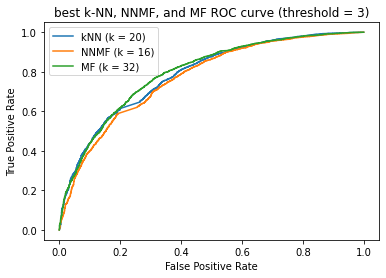

In [6]:
def plot_ROC_curve(pred, label):
    y_real = []
    y_pred = []
    for i, p in enumerate(pred):
        y_pred.append(pred[i].est)
        y_real.append(int(test_data[i][2] >= 3))
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    plt.plot(fpr, tpr, label=label)

train_data, test_data = train_test_split(dataset, test_size=.1)

pred = KNNWithMeans(k=20,sim_options={"name":"pearson"},verbose=False).fit(train_data).test(test_data)
plot_ROC_curve(pred, "kNN (k = 20)")

pred = NMF(n_factors=16,verbose=False).fit(train_data).test(test_data)
plot_ROC_curve(pred, "NNMF (k = 16)")

pred = SVD(n_factors=32,biased=True,verbose=False).fit(train_data).test(test_data)
plot_ROC_curve(pred, "MF (k = 32)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("best k-NN, NNMF, and MF ROC curve (threshold = 3)")
plt.legend(loc="best")
plt.show()

Precision is the fraction of liked and recommended items over the whole recommendation
Recall is the fraction of liked and recommended items over everything liked.

We use KNN to estimate movie ratings and determine which movies to recommend to users. Below are the graphs showing the relations between percision, recall and t of our recommendation.

In [7]:
ts = [t for t in range(1, 26)]
def precision_recall(model):
    precision = []
    recall = []
    kf = KFold(n_splits=10)
    for t in ts:
        precision_sum_t = 0
        recall_sum_t = 0
        for train_data, test_data in kf.split(dataset):
            G = {}
            user_count = {}
            for user,movie,rating in test_data:
                if rating >= 3:
                    G[user] = G.get(user, set())
                    G[user].add(movie)
                user_count[user] = user_count.get(user, 0) + 1
            trimmed_data = []
            for user,movie,rating in test_data:
                if user_count[user] >= t and user in G:
                    trimmed_data.append((user,movie,rating))
            pred = model.fit(train_data).test(trimmed_data)
            user_recommendation = {}
            for user, movie, _, pred_rating, _ in pred:
                user_recommendation[user] = user_recommendation.get(user, []) + [(pred_rating, movie)]
            precision_sum = 0
            recall_sum = 0
            for user in user_recommendation.keys():
                sorted_recommendation = sorted(user_recommendation[user],reverse=True)
                S_t = set(list(map(lambda x: x[1], sorted_recommendation[:t])))
                precision_sum += len(S_t.intersection(G[user]))/float(len(S_t))
                recall_sum += len(S_t.intersection(G[user]))/float(len(G[user]))
            precision_sum_t += precision_sum/len(user_recommendation)
            recall_sum_t += recall_sum/len(user_recommendation)
        precision.append(precision_sum_t/10)
        recall.append(recall_sum_t/10)
    return precision, recall

def plot_precision_recall(precision, recall, tital):
    plt.plot(ts, precision)
    plt.xlabel("t")
    plt.ylabel("Average Precision")
    plt.title(tital + " cross validation average precision vs t")
    plt.show()

    plt.plot(ts, recall)
    plt.xlabel("t")
    plt.ylabel("Average Recall")
    plt.title(tital + " cross validation average recall vs t")
    plt.show()

    plt.plot(recall,precision)
    plt.xlabel("Average Recall")
    plt.ylabel("Average Precision")
    plt.title(tital + " cross validation average precision vs average recall")
    plt.show()
    return

As we can see, precision and t have an negative correlation, which means precision score gets lower as we increase t; recall and t have an positive correlation, which means recall score gets higher as we increase t (the recall score increases slower as t gets larger); precision and recall have negative correlation, which means precision score is lower when recall score is higher.

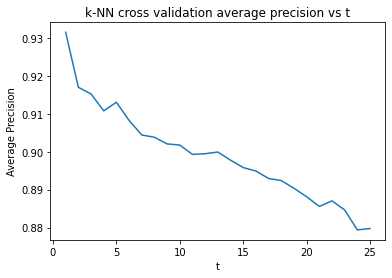

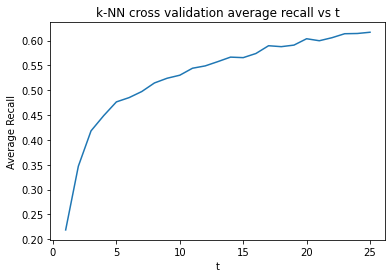

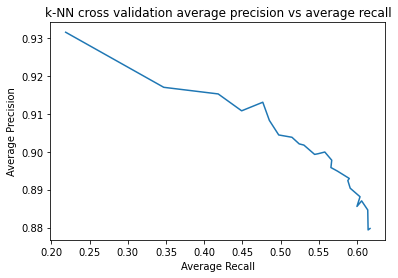

In [8]:
knn_precision, knn_recall = precision_recall(KNNWithMeans(k=20,sim_options={"name":"pearson"},verbose=False))
plot_precision_recall(knn_precision, knn_recall, "k-NN")

Similar to KNN result, precision and t have an negative correlation, which means precision score gets lower as we increase t; recall and t have an positive correlation, which means recall score gets higher as we increase t (the recall score increases slower as t gets larger); precision and recall have negative correlation, which means precision score is lower when recall score is higher.

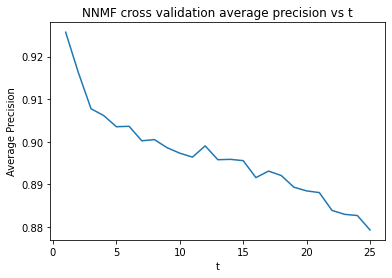

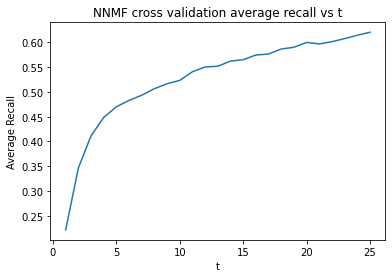

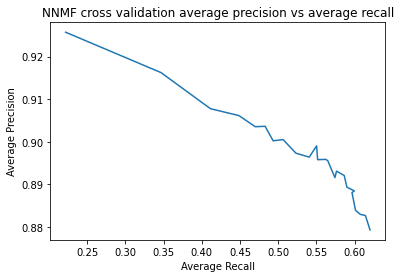

In [9]:
nnmf_precision, nnmf_recall = precision_recall(NMF(n_factors=16,verbose=False))
plot_precision_recall(nnmf_precision, nnmf_recall, "NNMF")

Similar to previous two result, precision and t have an negative correlation, which means precision score gets lower as we increase t; recall and t have an positive correlation, which means recall score gets higher as we increase t (the recall score increases slower as t gets larger); precision and recall have negative correlation, which means precision score is lower when recall score is higher.

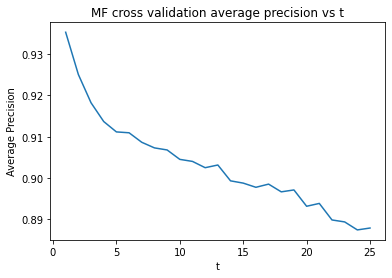

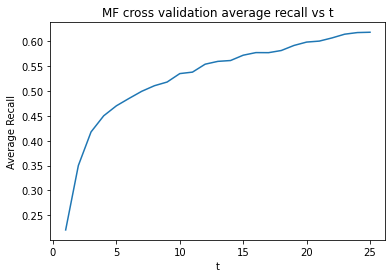

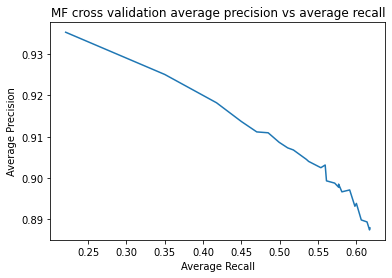

In [10]:
mf_precision, mf_recall = precision_recall(SVD(n_factors=32,biased=True,verbose=False))
plot_precision_recall(mf_precision, mf_recall, "MF")

Here we show the precision-recall curve of k-NN, NNMF, and MF. As we can see, MF with bias-based collaborative filter's curve is slightly above the others', which means MF would have better precision and recall score in almost all given t value. Thus we can conclude that MF with bias-based collaborative filter allows us to produce the most relevant recommendations.

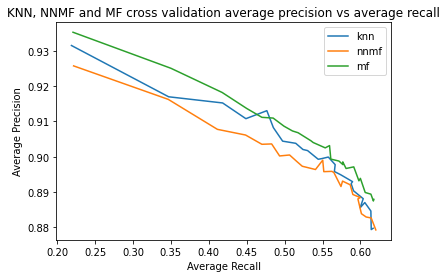

In [11]:
plt.plot(knn_recall, knn_precision, label = "knn")
plt.plot(nnmf_recall, nnmf_precision, label = "nnmf")
plt.plot(mf_recall, mf_precision, label = "mf")
plt.xlabel("Average Recall")
plt.ylabel("Average Precision")
plt.title("KNN, NNMF and MF cross validation average precision vs average recall")
plt.legend(loc="best")
plt.show()